In [1]:
import os
import psycopg2

In [2]:
# ================== Connect to Database ==================
DB_USER = os.getenv("DB_USER")
DB_PASSWORD = os.getenv("DB_PASSWORD")
DB_NAME = os.getenv("DB_NAME")
DB_HOST = os.getenv("DB_HOST")
DB_PORT = os.getenv("DB_PORT")

def get_db_connection():
	return psycopg2.connect(
    dbname=DB_NAME,
    user=DB_USER,
    password=DB_PASSWORD,
    host=DB_HOST,
    port=DB_PORT
)

In [3]:
# Custom SQL
def getExactItem(item_name):
  """Return exact information of an item by its name"""
  try:
    with get_db_connection() as conn:
      with conn.cursor() as cur:
        cur.execute(
          """
          SELECT
            title, price, description
          FROM menu_items
          WHERE title = %s
          """, (item_name,)
        )
        row = cur.fetchone()
        return list(row)
  except Exception as e:
    return [f"Error: {e}", 0, ""]
  
def getSubCategories(main_cat):
  """Return exact information of an item by its name"""
  try:
    with get_db_connection() as conn:
      with conn.cursor() as cur:
        cur.execute(
          """
          SELECT 
            DISTINCT sub_category
          FROM menu_items
          WHERE main_category = %s
          """, (main_cat,)
        )
        rows = cur.fetchall()
        return [r[0] for r in rows if r[0] is not None]
  except Exception as e:
    return [f"Error: {e}"]
  
def getTopItemsFromMain(main_cat):
  """Recommend top 5 items from main category if it has no subcategories"""
  try:
    with get_db_connection() as conn:
      with conn.cursor() as cur:
        cur.execute(
          """
          SELECT 
            COUNT(DISTINCT sub_category)
          FROM menu_items
          WHERE main_category = %s
          AND sub_category != 'NaN'
          """, (main_cat,)
        )
        count = cur.fetchone()[0]
        if count == 0:
          cur.execute(
            """
            SELECT 
              title, price, description
            FROM menu_items
            WHERE main_category = %s
            ORDER BY RANDOM()
            LIMIT 5
            """, (main_cat,)
          )
          rows = cur.fetchall()
          rows = [list(r) for r in rows]
          return rows
        else:
          return getSubCategories(main_cat)
  except Exception as e:
    return [(f"Error: {e}", 0, "")]
  
def getTopItemsFromSub(sub_cat):
  """Recommend top 5 items from sub category"""
  try:
      with get_db_connection() as conn:
        with conn.cursor() as cur:
          cur.execute(
            """
            SELECT title, price, description
            FROM menu_items
            WHERE sub_category = %s
            ORDER BY RANDOM()
            LIMIT 5
            """, (sub_cat,)
          )
          rows = cur.fetchall()
          rows = [list(r) for r in rows]
          return rows
  except Exception as e:
    return [(f"Error: {e}", 0, "")]

In [6]:
mappings = {
  'Cà phê': {
    'Cà phê máy': ['Latte Classic', 'Latte Bạc Xỉu', 'Latte Coconut', 'Latte Hazelnut', 'Latte Caramel', 'Latte Almond', 'Latte Nóng'],
    'Cà phê phin': ['Bạc Xỉu Foam Dừa', 'Bạc Xỉu Caramel Muối', 'Đường Đen Sữa Đá','Bạc Xỉu Nóng',
                    'Bạc Xỉu', 'Cà Phê Sữa Đá', 'Cà Phê Đen Đá', 'Cà Phê Sữa Nóng', 'Cà Phê Đen Nóng'],
    'Cold Brew': ['Cold Brew Kim Quất', 'Cold Brew Sữa Tươi', 'Cold Brew Truyền Thống'],
    'A-Mê': ['A-Mê Tuyết Quất', 'A-Mê Tuyết Mơ', 'A-Mê Tuyết Đào', 'A-Mê Quất', 'A-Mê Mơ', 'A-Mê Đào', 'A-Mê Classic', 'Americano Nóng'],
    'Espresso': ['Espresso Đá','Cappuccino Đá', 'Caramel Macchiato Đá', 'Cappuccino Nóng', 'Caramel Macchiato Nóng', 'Espresso Nóng']
  },

  'Thức uống đá xay': {
    'Đá xay': ['Frosty Cà Phê Đường Đen', 'Frosty Caramel Arabica', 'Frosty Bánh Kem Dâu', 'Frosty Phin-Gato', 'Frosty Trà Xanh',
                'Frosty Cà Phê Đường Đen', 'Frosty Caramel Arabica', 'Frosty Phin-Gato', 'Frosty Trà Xanh', 'Frosty Bánh Kem Dâu'],
    'Đá xay có lớp whipping cream': ['Frappe Choco Chip', 'Frappe Hazelnut', 'Frappe Caramel', 'Frappe Almond', 'Frappe Espresso', 'Frappe Coconut Coffee', 'Frappe Matcha'],
  },

  'Matcha': {
    '': ['Matcha Yuzu Đá Xay', 'Matcha Yuzu', 'Matcha Đào Đá Xay', 'Matcha Đào', 'Matcha Okinawa Trân Châu Hoàng Kim', 'Matcha Sữa Dừa Đá Xay', 'Matcha Sữa Dừa',
        'Matcha Latte', 'Matcha Tinh Khiết', 'Trà Xanh - Xinh Chẳng Phai', 'Trà Xanh - Yêu Chẳng Phai', 'Matcha Latte Tây Bắc Sữa Yến Mạch', 'Trà Xanh Tây Bắc',
        'Matcha Latte Tây Bắc Sữa Yến Mạch (Nóng)', 'Trà Xanh Nước Dừa', 'Trà Xanh Nước Dừa Yuzu', 'Matcha Latte Tây Bắc (Nóng)', 'Matcha Latte Tây Bắc']
  },

  'Trà trái cây - Hi Tea': {
    'Hi Tea': ['Hi-Tea Yuzu Kombucha', 'Hi-Tea Đào Kombucha', 'Hi-Tea - Xinh Chẳng Phai', 'Hi-Tea Đào', 'Hi-Tea Vải', 'Hi-Tea Yuzu Trân Châu', 'Hi-Tea - Yêu Chẳng Phai',
                'Hi-Tea Đá Tuyết Mận Muối Trân Châu', 'Hi-Tea Dâu Tây Mận Muối Trân Châu', 'Hi-Tea Kim Quất Bưởi Hồng Mandarin', 'Dâu Phô Mai'],
    'Trà trái cây': ['Oolong Tứ Quý Sen',  'Oolong Tứ Quý Sen (Nóng)', 'Oolong Tứ Quý Dâu Trân Châu', 'Oolong Tứ Quý Vải',
                      'Oolong Tứ Quý Kim Quất Trân Châu', 'Trà Đào Cam Sả - Nóng', 'Trà Đào Cam Sả - Đá', 'Oolong Berry']
  },

  'Trà sữa': {
    '': ['Trà sữa Oolong Nướng Trân Châu', 'Trà Đen Macchiato', 'Hồng Trà Sữa Trân Châu', 'Hồng Trà Sữa Nóng',
        'Trà Sữa Oolong Tứ Quý Sương Sáo', 'Trà Sữa Oolong Nướng Sương Sáo','Trà Đào - Yêu Chẳng Phai',
        'Trà Sữa Oolong BLao', 'Trà sữa Oolong Nướng (Nóng)', 'Chocolate Nóng', 'Chocolate Đá']
  },

  'Bánh': {
    'Bánh ngọt': ['Mochi Kem Trà Sữa Trân Châu', 'Mochi Kem Matcha', 'Mochi Kem Chocolate', 'Mochi Kem Việt Quất', 'Mochi Kem Phúc Bồn Tử',
                  'Mousse Matcha', 'Mousse Tiramisu', 'Mousse Gấu Chocolate', 'Matcha Burnt Cheesecake', 'Burnt Cheesecake', 'Mít Sấy', 'Butter Croissant Sữa Đặc'],
    'Bánh mặn': ['Bánh Mì Que Bò Nấm Xốt Bơ', 'Bánh Mì Que Chà Bông Phô Mai Bơ Cay', 'Bánh Mì Que Pate Cột Đèn', 'Chà Bông Phô Mai', 'Croissant trứng muối', 'Butter Croissant']
  },

  'Đồ ăn chế biến': {
    '': ['Spaghetti Bò Bằm', 'Cơm Chiên Hải Sản']
  },

  'Cà phê gói mang đi': {
    '': ['Cà Phê Đen Đá Túi (30 gói x 16g)', 'Cà Phê Đen Đá Hộp (14 gói x 16g)', 'Cà Phê Hoà Tan Đậm Vị Việt (18 gói x 16 gam)',
        'Cà Phê Sữa Đá Hòa Tan Túi 25x22G', 'Cà Phê Rang Xay Original 1 250G', 'Cà Phê Sữa Đá Hòa Tan (10 gói x 22g)', 'Cà Phê Nguyên Hạt Arabica TCH (200gr)']
  }
}

In [7]:
import re
import unicodedata

class QueryClassifier:
  def __init__(self, mappings):
    self.mappings = mappings
    self.main_cats, self.sub_cats, self.items = self.build_lookup_tables()
    
  def normalize_text(self, text):
    # Convert Vietnamese to accent-free + lowercase for robust matching
    text = unicodedata.normalize('NFD', text)
    text = ''.join(ch for ch in text if unicodedata.category(ch) != 'Mn')
    return text.lower().strip()

  def build_lookup_tables(self):
    main_cats, sub_cats, items = set(), set(), set()
    for main_cat, subs in self.mappings.items():
      main_cats.add(main_cat)
      for sub_cat, drinks in subs.items():
        if sub_cat:
          sub_cats.add(sub_cat)
        for drink in drinks:
          items.add(drink)
    return main_cats, sub_cats, items

  def classify_query(self, query):
    query_norm = self.normalize_text(query)

    # Normalize all names for comparison
    norm_main = {self.normalize_text(c): c for c in self.main_cats}
    norm_sub = {self.normalize_text(c): c for c in self.sub_cats}
    norm_items = {self.normalize_text(i): i for i in self.items}

    # Exact beverage (title) match
    for norm_name, original in norm_items.items():
      if norm_name in query_norm:
        return {"type": "item", "keyword": original}

    # Sub-category match
    for norm_name, original in norm_sub.items():
      if re.search(rf"\b{re.escape(norm_name)}\b", query_norm):
        return {"type": "sub_category", "keyword": original}

    # Main category match
    for norm_name, original in norm_main.items():
      if re.search(rf"\b{re.escape(norm_name)}\b", query_norm):
        return {"type": "main_category", "keyword": original}

    return {"type": "unknown", "keyword": None}

In [8]:
def hand_customer_query(query, mappings):
  queryclassifier = QueryClassifier(mappings)
  classification = queryclassifier.classify_query(query)
  qtype = classification["type"]
  keyword = classification["keyword"]

  if qtype == "item":
    return getExactItem(keyword)
  elif qtype == "sub_category":
    return getTopItemsFromSub(keyword)
  elif qtype == "main_category":
    return getTopItemsFromMain(keyword)
  else:
    return [{"message": "Xin lỗi, tôi không tìm thấy sản phẩm phù hợp."}]

In [14]:
from langchain_google_genai import ChatGoogleGenerativeAI

API_KEY = os.getenv("GOOGLE_API_KEY")

def initModelLLM():
  try:
    model = ChatGoogleGenerativeAI(
      model='gemini-2.0-flash',
      google_api_key=API_KEY
    )
    return model
  except Exception as e:
    print(f"Cannot load model, reason: {e}")
    return None
  
llm = initModelLLM()

In [ ]:
# # Serve customer tools
# welcome_customer_tool = next(tool for tool in all_tools if tool.name == "welcome_customer")
# welcome_customer_node = ToolNode([welcome_customer_tool], name='welcome_customer')

# handle_customer_query_tool = next(tool for tool in all_tools if tool.name == "hand_customer_query")
# handle_customer_query_node = ToolNode([handle_customer_query_tool], name='hand_customer_query')

In [15]:
# prompt = """
# You are a staff member at MT coffee shop
# - When starting a conversation, always call the 'welcome_customer' tool to greet the customer. 
# - When a customer asks about a drink, call the 'hand_customer_query' tool with their question.
# - This tool will return data from SQL in the form of a list:
#   + One item: ["Title", Price, "Description"]
#   + Many items: [["Title", Price, "Description"], ...]
# - Your task is to read the data and respond to the customer in Vietnamese, neatly presented:
#   + If there are many items: list each item with bullet points, including the price and description.
#   + If one item: describe that dish in detail.
# - If the tool returns an error message, apologize to the customer and say that no suitable product was found.
# """

prompt = """
You are a staff member at MT coffee shop.
- When starting a conversation, greet the customer.
- When the customer asks about a drink, call hand_customer_query with their question.
- Format the result (list of items or single item) into Vietnamese, listing bullet points if multiple, or detailed if single.
- If no suitable product, apologize and say no product found.
"""

In [16]:
from langchain.agents import create_agent
from langchain.tools import tool

@tool
def welcome_customer() -> str:
  """Say hello to the customer with a friendly voice"""
  return "Chào mừng bạn đến quán cà phê MT, không biết tôi có thể hỗ trợ gì được cho bạn?"

@tool
def hand_customer_query(query) -> list:
  """Tool to find a beverage according to the customer's request"""
  qc = QueryClassifier(mappings)
  classification = qc.classify_query(query)
  
  if classification["type"] == "item":
    return getExactItem(classification["keyword"])

  elif classification["type"] == "sub_category":
    return getTopItemsFromSub(classification["keyword"])

  elif classification["type"] == "main_category":
    return getTopItemsFromMain(classification["keyword"])

  else:
    return ["Tôi chưa hiểu bạn muốn uống gì. Bạn có thể mô tả rõ hơn không?"]

In [17]:
agent = agent = create_agent(
  model=llm,
  tools=[welcome_customer, hand_customer_query],
  system_prompt=prompt
)

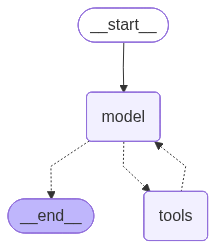

In [18]:
agent

In [19]:
state = {"messages": []}

while True:
  user_input = input("Customer: ")
  if user_input.lower().strip() == "exit":
    print("Kết thúc hội thoại.")
    break
    
  state["messages"].append({"role": "user", "content": user_input})
  result = agent.invoke(state)
  
  last = result["messages"][-1]
  print("Agent:", last.content)
  
  state = result 

Agent: Chào bạn! Quán mình có các loại bánh ngọt sau ạ:
* Mít Sấy - 20000 VNĐ: Mít sấy khô vàng ươm, giòn rụm, giữ nguyên được vị ngọt lịm của mít tươi.
* Mochi Kem Việt Quất - 19000 VNĐ: Bao bọc bởi lớp vỏ Mochi dẻo thơm, bên trong là lớp kem lạnh cùng nhân việt quất đặc trưng thơm thơm, ngọt dịu. Sản phẩm phải bảo quản mát và dùng ngon nhất trong 2h sau khi nhận hàng.
* Mousse Matcha - 29000 VNĐ: Khám phá từng tầng vị trà xanh thơm lừng xen kẽ lớp kéo béo dịu với đậu đỏ.
* Mochi Kem Phúc Bồn Tử - 19000 VNĐ: Bao bọc bởi lớp vỏ Mochi dẻo thơm, bên trong là lớp kem lạnh cùng nhân phúc bồn tử ngọt ngào. Sản phẩm phải bảo quản mát và dùng ngon nhất trong 2h sau khi nhận hàng.
* Butter Croissant Sữa Đặc - 35000 VNĐ: Bánh Butter Croissant bạn đã yêu, nay yêu không lối thoát khi được chấm cùng sữa đặc. Thơm bơ mịn sữa, ngọt ngào lòng nhau!
Agent: Chào bạn! Quán mình có bán các loại cà phê sau:
* A-Mê
* Cà phê máy
* Cold Brew
* Cà phê phin
* Espresso
Agent: Chào bạn! Quán mình có Matcha Latte